In [1]:
#%matplotlib notebook
%matplotlib inline

import math
import sqlite3
from html import escape
from itertools import groupby
from operator import itemgetter
from pathlib import Path

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import HTML, display
from docutils.core import publish_parts
from mpl_toolkits.mplot3d import Axes3D  # workaround for older mpl

plt.style.use('ggplot')

In [2]:
conn = sqlite3.connect('compression.db')

In [3]:
def render_rst(rst):
    """
    Given reStructuredText *rst*, return the rendered HTML
    content, excluding the surrounding outer-most ``<body>``
    elements.
    """
    return HTML(publish_parts(rst, writer_name='html')['html_body'])

In [4]:
render_rst(Path('README.rst').read_text())

Name,Type,Description
compressor,TEXT,The name of the compressor
options,TEXT,The options to execute the compressor with (if any)
level,TEXT,The compression level to use
Name,Type,Description
machine,TEXT,The label provided on by --machine on the command line
arch,TEXT,The dpkg architecture of the machine
compressor,TEXT,The name of the compressor
options,TEXT,The options to execute the compressor with (if any)
level,TEXT,The compression level to use
succeeded,INTEGER,"1 if the compression run succeeded, and 0 if it failed"


## Analysis Functions

Some convenience functions for rendering the output of SQL queries as tables
and graphs; these are not important to the analysis -- feel free to skip down
to the "Analysis Results" heading.

In [5]:
def render_table(cur):
    """
    Given *cur*, a cursor containing a database result set, return a string
    containing the result set rendered as an HTML ``<table>`` element.
    """
    columns = [r[0] for r in cur.description]
    rows = list(cur)
    cur.close()
    headers = "".join(
        f"<th>{escape(str(header))}</th>"
        for header in columns
    )
    data = "\n".join(
        f"<tr>{html_row}</tr>"
        for row in rows
        for html_row in ("".join(
            f"<td>{escape(str(cell))}</td>"
            for cell in row
        ),)
    )
    return HTML(f"""
<table>
<thead><tr>{headers}</tr></thead>
<tbody>{data}</tbody>
</table>""")

In [6]:
def transpose(seq):
    return list(zip(*seq))

In [7]:
def render_xy(cur, log=''):
    """
    Given *cur*, a cursor containing a database result set, plot the results
    on an X-Y scatter graph. The cursor is expected to contain 3 columns:
    
    * The first column must be the "series" column, and must be the first
      column by which the result set is ordered. It can be any data-type but
      is typically a string indicating the series of data that the row belongs
      to. The name of this column is ignored, but the content will be used in
      the key of the graph.
      
    * The second column must be the "X" column, and must be numeric values
      for the X-axis of the graph. The column name will be used as the X-axis
      title.
      
    * The third column must be the "Y" column, and must be numeric values for
      the Y-axis of the graph. The column name will be used as the Y-axis
      title.
    """
    style = {'marker': 'o', 'linestyle': '-'}
    cols = [c[0] for c in cur.description]
    if len(cols) != 3:
        raise ValueError('query must return 3 columns')
    ax = plt.axes(xscale='log' if 'x' in log else 'linear',
                  yscale='log' if 'y' in log else 'linear')
    for series, rows in groupby(cur, key=itemgetter(0)):
        data = transpose((row[1], row[2]) for row in rows)
        ax.plot(data[0], data[1], label=series, **style)
    ax.set_xlabel(cols[1])
    ax.set_ylabel(cols[2])
    ax.legend()

In [8]:
def render_multi_xy(cur, log='', fmt='o-', labels=True):
    """
    Given *cur*, a cursor containing a database result set, plot the results on
    multiple X-Y scatter graphs within a figure. Each plot shares its X and
    Y scales making the graphs comparable. The cursor must contain 4 columns:
    
    * The first is the graph "title" column. The result set must use this as
      the primary sorting key. Each unique value in this column will produce a
      separate output graph titled with that value. The column name is ignored.
      
    * The second is the "series" column. The result set must use this as the
      secondary sorting key. Each unique value in this column will form a
      separate series of data in the containing graph. The column name is
      ignored.

    * The third is the "label" column. The result set must use this as the
      tertiary sorting key. Each value in this column is a label for the
      point specified by the X and Y axis columns that follow. Not all point
      labels are rendered; only the first and last labels in a given series
      are shown.
      
    * The fourth column must be the "X" column, and must be numeric values
      for the X-axis of the graph. The column name will be used as the X-axis
      title.
      
    * The fifth column must be the "Y" column, and must be numeric values for
      the Y-axis of the graph. The column name will be used as the Y-axis
      title.
    
    If *log* is specified it indicates which axes should be log scaled. By
    default this is an empty string meaning all axes are linearly scaled.
    Specifying 'x' would use a log scale on the X axis, but not the Y axis.
    """
    cols = [c[0] for c in cur.description]
    if len(cols) != 5:
        raise ValueError('query must return 5 columns')
    graphs = {}
    for title, rows in groupby(cur, key=itemgetter(0)):
        graphs[title] = [(row[1], row[2], row[3], row[4]) for row in rows]
    rows = len(graphs) // 2 + len(graphs) % 2
    fig, axs = plt.subplots(
        rows, 2, figsize=(9, rows * 3),
        sharex=True, sharey=True)
    for ax, title in zip(axs.flat, graphs):        
        graph = graphs[title]
        for series, rows in groupby(graph, key=itemgetter(0)):
            data = transpose((row[1], row[2], row[3]) for row in rows)
            ax.plot(data[1], data[2], fmt, label=series)
            if labels:
                ax.annotate(data[0][0], (data[1][0], data[2][0]))
                ax.annotate(data[0][-1], (data[1][-1], data[2][-1]))
        ax.set_xlabel(cols[3])
        ax.set_ylabel(cols[4])
        if 'x' in log:
            ax.set_xscale('log')
        if 'y' in log:
            ax.set_yscale('log')
        ax.legend()
        ax.set_title(title)
        ax.label_outer()
    if len(graphs) % 2:
        axs.flat[-1].set(visible=False)

In [9]:
def render_xyz(cur, log='', fmt='o-', labels=True):
    """
    Given *cur*, a cursor containing a database result set, plot the results on
    three X-Y scatter graphs. The cursor is expected to contain 5 columns:
    
    * The first is the "series" column. The result set must use this as the
      primary sorting key. Each unique value in this column will form a
      separate series of data in the containing graph. The column name is
      ignored.
      
    * The second is the "label" column. The result set must use this as the
      secondary sorting key. Each value in this column is a label for the
      three-dimensional point specified by the X, Y, and Z axis columns that
      follow. Not all point labels are rendered; only the first and last labels
      in a given series are shown.
      
    * The third column must be the "X" column, and must be numeric values
      for the X-axis of the graph. The column name will be used as the X-axis
      title.
      
    * The fourth column must be the "Y" column, and must be numeric values for
      the Y-axis of the graph. The column name will be used as the Y-axis
      title.
      
    * The fifth column must be the "Z" column, and must be numeric values for
      the Z-axis of the graph. The column name will be used as the Z-axis
      title.
      
    The "X" and "Y" columns will be plotted on the top-left "common" graph. The
    "X" and "Z" columns will be plotted below the common graph, and the "Y" and
    "Z" columns will be plotted to the right of the common graph.
    
    If *log* is specified it indicates which axes should be log scaled. By
    default this is an empty string meaning all axes are linearly scaled.
    Specifying 'xy' would use a log scale on the X and Y axes, but not the Z
    axis.
    """
    cols = [c[0] for c in cur.description]
    if len(cols) != 5:
        raise ValueError('query must return 5 columns')
    fig, axs = plt.subplots(2, 2, figsize=(9, 9))
    cur = list(cur)
    indexes = {'x': 2, 'y': 3, 'z': 4}
    for ax, ax_cols in zip(axs.flat, ('xy', 'zy', 'xz')):
        getter = itemgetter(1, indexes[ax_cols[0]], indexes[ax_cols[1]])
        for series, rows in groupby(cur, key=itemgetter(0)):
            data = transpose(getter(row) for row in rows)
            ax.plot(data[1], data[2], fmt, label=series)
            if labels:
                ax.annotate(data[0][0], (data[1][0], data[2][0]))
                ax.annotate(data[0][-1], (data[1][-1], data[2][-1]))
        ax.set_xlabel(cols[indexes[ax_cols[0]]])
        ax.set_ylabel(cols[indexes[ax_cols[1]]])
        if ax_cols == 'xy':
            plt.figlegend(loc='center left', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
        if ax_cols[0] in log:
            ax.set_xscale('log')
            #ax.set_xscale(LogScale(base=2))
        if ax_cols[1] in log:
            ax.set_yscale('log')
    axs[1, 1].set(visible=False)
    return fig

In [10]:
def render_3d(cur, fmt='o-', labels=True):
    """
    Given *cur*, a cursor containing a database result set, plot the results on
    a 3D X-Y-Z scatter graph. The cursor is expected to contain 5 columns:
    
    * The first is the "series" column. The result set must use this as the
      primary sorting key. Each unique value in this column will form a
      separate series of data in the containing graph. The column name is
      ignored.
      
    * The second is the "label" column. The result set must use this as the
      secondary sorting key. Each value in this column is a label for the
      three-dimensional point specified by the X, Y, and Z axis columns that
      follow. Not all point labels are rendered; only the first and last labels
      in a given series are shown.

    * The third column must be the "X" column, and must be numeric values
      for the X-axis of the graph. The column name will be used as the X-axis
      title.
      
    * The fourth column must be the "Y" column, and must be numeric values for
      the Y-axis of the graph. The column name will be used as the Y-axis
      title.
      
    * The fifth column must be the "Z" column, and must be numeric values for
      the Z-axis of the graph. The column name will be used as the Z-axis
      title.
    """
    cols = [c[0] for c in cur.description]
    if len(cols) != 5:
        raise ValueError('query must return 5 columns')
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(projection='3d')
    getter = itemgetter(1, 2, 3, 4)
    for series, rows in groupby(cur, key=itemgetter(0)):
        data = transpose(getter(row) for row in rows)
        ax.plot(data[1], data[2], data[3], fmt, label=series)
        if labels:
            ax.text(data[1][0], data[2][0], data[3][0], data[0][0])
            ax.text(data[1][-1], data[2][-1], data[3][-1], data[0][-1])
    ax.set_xlabel(cols[2])
    ax.set_ylabel(cols[3])
    ax.set_zlabel(cols[4])
    ax.legend()
    return fig

## Analysis Results

### A Caution

A word of warning before diving into these results: it would be a mistake to apply
this analysis generally. In several ways it is quite specific to the circumstances
surrounding it. For example, later on we make the assumption that the time spent
reading a compressed archive consists of the I/O time reading the archive, followed
by the decompression time.
This is *not* generally the case: often decompression can proceed simultaneously
with reading, but in the case of the initramfs its archive is typically read by the
bootloader (GRUB, uboot, etc.) before control is passed to the Linux kernel which
subsequently handles decompression.

Further, we're only looking at uncompressed CPIO initramfs archives as inputs. These
typically include few (or no) pre-compressed artefacts, and largely consist of
kernel modules (code native to a given platform) and shell scripts (text files).
Needless to say, these are not representative of many other common compression
scenarios.

In other words, if you're interested in how these compressors handle initramfs
archives: you're in the right place. Otherwise, feel free to adapt the gather script
to work on your own inputs, and re-use the analysis tools in this notebook, but don't
be at all surprised if the conclusions are completely different!

### Combinations tested

A list of all the machines (and architectures) tested:

In [11]:
render_table(conn.execute("""
SELECT DISTINCT
    machine AS "Machine",
    arch AS "Architecture"
FROM results
"""))

Machine,Architecture
AMD Ryzen 32GB,amd64
Pi 4 8GB,arm64
Pi 4 8GB,armhf
Pi Zero 2 512MB,arm64
Pi Zero 2 512MB,armhf
SiFive Unmatched 16 GiB,riscv64


A list of all the compressors and options tested:

In [12]:
render_table(conn.execute("""
SELECT
    compressor AS "Compressor",
    options AS "Options",
    GROUP_CONCAT(level) AS "Levels"
FROM tests
GROUP BY compressor, options
ORDER BY compressor, options
"""))

Compressor,Options,Levels
bzip2,,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
bzip2,-s,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
cat,,
gzip,,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
lbzip2,,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
lz4,,"-1,-10,-11,-12,-2,-3,-4,-5,-6,-7,-8,-9"
lzip,,"-0,-1,-2,-3,-4,-5,-6,-7,-8,-9"
pigz,,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
plzip,,"-0,-1,-2,-3,-4,-5,-6,-7,-8,-9"
xz,,"-0,-1,-2,-3,-4,-5,-6,-7,-8,-9"


Notes:
* The `-e` option for `xz` enables "extreme" (!) compression
* The `-s` option for `bzip2` reduces memory usage
* The `-T0` option for `zstd` and `xz` enables multi-threaded operation
* `lbzip2` is the parallel version of `bzip2`
* `plzip` is the parallel version of `lzip`
* `pigz` is the parallel version of `gzip`
* `cat` is included to measure compression vs no compression

### Dangerous combinations

Show all compressor+option combinations that failed to produce a result

In [13]:
render_table(conn.execute("""
SELECT
    machine AS "Machine",
    arch AS "Architecture",
    compressor_options AS "Compressor",
    MIN(level) AS "Level"
FROM analysis
WHERE succeeded = 0
GROUP BY machine, arch, compressor_options
"""))

Machine,Architecture,Compressor,Level
Pi Zero 2 512MB,arm64,lzip,-7
Pi Zero 2 512MB,arm64,plzip,-5
Pi Zero 2 512MB,arm64,xz,-7
Pi Zero 2 512MB,arm64,xz -T0,-4
Pi Zero 2 512MB,arm64,xz -e,-7
Pi Zero 2 512MB,arm64,xz -e -T0,-3
Pi Zero 2 512MB,arm64,zstd,-16
Pi Zero 2 512MB,arm64,zstd -T0,-11
Pi Zero 2 512MB,armhf,lzip,-8
Pi Zero 2 512MB,armhf,plzip,-5


From the table above we can see that only the Pi Zero 2 has an issue, and that
only the more aggressive options of ``zstd`` and the LZMA compressors tend to
cause a direct
failure. However, it's worth bearing in mind that these tests were run on
otherwise idle and unloaded systems. We should strive to be as minimal as
possible in both memory and time usage because:

* The more memory we use, the more chance of pushing other services into OOM
  failure. For example, on the Pi Zero 2 (and 3A+) with the arm64 architecture,
  the typical amount of RAM available at runtime with all "default" services
  loaded is only around 200MB. If our compressor takes 50MB of RAM, and a daemon
  is running that takes 100MB of RAM we're at serious risk of pushing the daemon
  into the waiting arms of the OOM killer.

* The more time we use, the more we risk being terminated prematurely. Consider
  that `unattended-upgrades` runs by default and that a kernel upgrade could
  well be running at shutdown time. If our compressor takes 4 minutes to run
  we're at serious risk of the user just pulling the plug (no one waits 4
  minutes for shutdown!).

## Query playground

In [14]:
all_machines_archs = [
    (f'{machine} ({arch})', (machine, arch))
    for machine, arch in 
        conn.execute("SELECT DISTINCT machine, arch FROM results ORDER BY 1")
]
all_compressors_options = [
    (f'{compressor}{" " if options else ""}{options}', (compressor, options))
    for compressor, options in
        conn.execute("SELECT DISTINCT compressor, options FROM tests ORDER BY 1")
]

Show selected compressor behaviour for one specific machine and architecture combination. Various options are included for customization of the output (logarithmic axes, 3D plot, etc.):

In [15]:
def compare_compressors(machine_arch, compressors_options,
                        max_duration=10000, max_resident=1000,
                        log_axes=False, three_d=False,
                        show_lines=True, show_labels=True):
    query = f"""
    WITH compressors_selected(compressor, options) AS (
        VALUES
        {','.join('(?, ?)' for item in compressors_options)}
    )
    SELECT
        compressor_options,
        level,
        comp_duration AS "Elapsed (s)",
        comp_max_mem / 1048576.0 AS "Max. resident size (MB)",
        comp_ratio AS "Compressed size (%)"
    FROM analysis JOIN compressors_selected USING(compressor, options)
    WHERE succeeded = 1
    AND machine = ?
    AND arch = ?
    AND comp_duration < ?
    AND comp_max_mem < ? * 1048576
    AND compressor <> 'cat'
    ORDER BY compressor_options, level_order
    """
    machine, arch = machine_arch
    params = [
        param
        for compressor, options in compressors_options
        for param in (compressor, options)
    ] + [machine, arch, max_duration, max_resident]
    cur = conn.execute(query, params)
    if three_d:
        render_3d(
            cur, fmt='o-' if show_lines else 'o', labels=show_labels)
    else:
        render_xyz(
            cur, log='xy' if log_axes else '',
            fmt='o-' if show_lines else 'o', labels=show_labels)
    plt.show()

def compare_compressors_ui():
    label = widgets.Layout(width='10em')
    machine_arch = widgets.Dropdown(options=all_machines_archs)
    compressors_options = widgets.SelectMultiple(
        options=all_compressors_options,
        rows=len(all_compressors_options),
        value=[value for label, value in all_compressors_options])
    max_duration = widgets.BoundedIntText(
        value=10000, min=10, max=10000, step=10)
    max_resident = widgets.BoundedIntText(
        value=1000, min=1, max=1000)
    three_d = widgets.Checkbox(
        value=False, description='3D graph', indent=False)
    log_axes = widgets.Checkbox(
        value=False, description='Log axes', indent=False)
    show_lines = widgets.Checkbox(
        value=True, description='Show lines', indent=False)
    show_labels = widgets.Checkbox(
        value=True, description='Show labels', indent=False)
    reset = widgets.Button(description='Reset')

    def log_axes_disable(change):
        log_axes.disabled = change['new']
    def three_d_disable(change):
        three_d.disabled = change['new']
    def reset_filters(btn):
        compressors_options.value = [
            value for label, value in all_compressors_options]
        machine_arch.value = all_machines_archs[0][1]
        max_duration.value = 10000
        max_resident.value = 1000
        three_d.value = False
        log_axes.value = False
        show_lines.value = True
        show_labels.value = True
    log_axes.observe(three_d_disable, 'value')
    three_d.observe(log_axes_disable, 'value')
    reset.on_click(reset_filters)

    controls = widgets.HBox([
        widgets.VBox([
            widgets.Label('Compressors'),
            compressors_options,
        ]),
        widgets.VBox([
            widgets.HBox([
                widgets.Label('Machine', layout=label),
                machine_arch,
            ]),
            widgets.HBox([
                widgets.Label('Max duration (s)',layout=label),
                max_duration,
            ]),
            widgets.HBox([
                widgets.Label('Max resident (MB)', layout=label),
                max_resident,
            ]),
            widgets.Label('Options'),
            log_axes,
            three_d,
            show_lines,
            show_labels,
            reset,
        ])
    ])
    output = widgets.interactive_output(
        compare_compressors, {
            'machine_arch': machine_arch,
            'compressors_options': compressors_options,
            'max_duration': max_duration,
            'max_resident': max_resident,
            'log_axes': log_axes,
            'three_d': three_d,
            'show_lines': show_lines,
            'show_labels': show_labels,
        }
    )
    display(controls, output)

compare_compressors_ui()

Output()

Show selected compressor behaviour across machines for one specific compressor and options combination. Various options are included for customization of the output (logarithmic axes, 3D plot, etc.):

In [17]:
def compare_machines(compressor_options, machines_archs,
                     max_duration=10000, max_resident=1000,
                     log_axes=False, three_d=False,
                     show_lines=True, show_labels=True):
    query = f"""
    WITH machines_selected(machine, arch) AS (
        VALUES
        {','.join('(?, ?)' for item in machines_archs)}
    )
    SELECT
        machine_arch,
        level,
        comp_duration AS "Elapsed (s)",
        comp_max_mem / 1048576.0 AS "Max. resident size (MB)",
        comp_ratio AS "Compressed size (%)"
    FROM analysis JOIN machines_selected USING(machine, arch)
    WHERE succeeded = 1
    AND compressor = ?
    AND options = ?
    AND comp_duration < ?
    AND comp_max_mem < ? * 1048576
    AND compressor <> 'cat'
    ORDER BY machine_arch, level_order
    """
    compressor, options = compressor_options
    params = [
        param
        for machine, arch in machines_archs
        for param in (machine, arch)
    ] + [compressor, options, max_duration, max_resident]
    cur = conn.execute(query, params)
    if three_d:
        render_3d(
            cur, fmt='o-' if show_lines else 'o', labels=show_labels)
    else:
        render_xyz(
            cur, log='xy' if log_axes else '',
            fmt='o-' if show_lines else 'o', labels=show_labels)
    plt.show()

def compare_machines_ui():
    label = widgets.Layout(width='10em')
    compressor_options = widgets.Dropdown(
        options=all_compressors_options)
    machines_archs = widgets.SelectMultiple(
        options=all_machines_archs,
        rows=len(all_machines_archs),
        value=[value for label, value in all_machines_archs])
    max_duration = widgets.BoundedIntText(
        value=10000, min=10, max=10000, step=10)
    max_resident = widgets.BoundedIntText(
        value=1000, min=1, max=1000)
    three_d = widgets.Checkbox(
        value=False, description='3D graph', indent=False)
    log_axes = widgets.Checkbox(
        value=False, description='Log axes', indent=False)
    show_lines = widgets.Checkbox(
        value=True, description='Show lines', indent=False)
    show_labels = widgets.Checkbox(
        value=True, description='Show labels', indent=False)
    reset = widgets.Button(description='Reset')

    def log_axes_disable(change):
        log_axes.disabled = change['new']
    def three_d_disable(change):
        three_d.disabled = change['new']
    def reset_filters(btn):
        compressor_options.value = all_compressors_options[0][1]
        machines_archs.value = [
            value for label, value in all_machines_archs]
        max_duration.value = 10000
        max_resident.value = 1000
        three_d.value = False
        log_axes.value = False
        show_lines.value = True
        show_labels.value = True
    log_axes.observe(three_d_disable, 'value')
    three_d.observe(log_axes_disable, 'value')
    reset.on_click(reset_filters)

    controls = widgets.HBox([
        widgets.VBox([
            widgets.Label('Machines'),
            machines_archs,
        ]),
        widgets.VBox([
            widgets.HBox([
                widgets.Label('Compressor', layout=label),
                compressor_options,
            ]),
            widgets.HBox([
                widgets.Label('Max duration (s)', layout=label),
                max_duration,
            ]),
            widgets.HBox([
                widgets.Label('Max resident (MB)', layout=label),
                max_resident,
            ]),
            widgets.Label('Options'),
            log_axes,
            three_d,
            show_lines,
            show_labels,
            reset,
        ])
    ])
    output = widgets.interactive_output(
        compare_machines, {
            'compressor_options': compressor_options,
            'machines_archs': machines_archs,
            'max_duration': max_duration,
            'max_resident': max_resident,
            'log_axes': log_axes,
            'three_d': three_d,
            'show_lines': show_lines,
            'show_labels': show_labels,
        }
    )
    display(controls, output)

compare_machines_ui()

Output()

## Useful combinations

Some rough observations from playing with the graphs above:

* `bzip2` has relatively poor time complexity compared to other algorithms; its
  clusters are consistently "right" of the other compressors under test on bottom
  graph indicating that, for the compression achieved, it's taking longer than
  others

* `zstd` has relatively poor memory complexity compared to other algorithms; its
  clusters are consistently "right" of the other compressors in the right-hand
  graph indicating that, for the memory used, it's achieved less compression
  compared to others

* `lbzip2`, the parallel version of `bzip2` goes a long way to improving the
  performance of the algorithm. However, in common with all the parallel variants
  this is at the cost of increased memory consumption

* `xz` and `lzip` (both LZMA based compressors) clearly produce the
  best overall compression ratio, but have by *far* the worst time complexity
  (they tail far off to the right on the Elapsed axis), and also poor memory
  complexity at least at their higher levels

* `zstd` looks like a decent trade-off between time spent and compression
  achieved. Roughly speaking it's slower than `lz4`, and quicker than `xz` and
  `lzip`, but produces compression only slightly worse than `xz` and `lzip`. As
  noted above, though, its memory complexity is a bit off. It also has a strange
  "curve" with a curious "knee" unlike any other compressor suggesting a lot of
  the "mid" levels (`-10` to `-15` roughly?) are probably not worthwhile

* Some parallelized compressors (in particular `xz` and `zstd` with their `-T0`
  option, and `plzip`) use *terrific* amounts of memory at their higher levels.
  It is particularly telling that the Pi Zero 2 results cease above 200MB of
  resident usage as everything trying to use more simply failed

* In contrast, `lz4` and the venerable `gzip` both have the worst compression
  ratios but excellent time and memory complexity. `gzip` consistently produces
  better compression, but `lz4` is (mostly) consistently quicker

* However, the parallel version of `gzip` (`pigz`) is impressive. With the
  exception of `lz4 -1`, `pigz` consistently produces better compression in less
  time, using less memory than `lz4` (`lz4 -1` *sometimes* beats it at speed, but
  provides little compression)

* There appears to be a significant difference in compression ratio between
  level `-1` of `lz4` and the later levels

* `lz4` and `gzip` appear to be constant memory algorithms (see the scale of
  the Y-axis on the resident size graphs for these compressors; the variation
  is on the scale of kilobytes)

From the above we can rule out certain compressor options (`zstd` above `-10`,
`xz` above `-6`, etc). However, we should have a general overview of how these
compressors fare against each other to see whether one is obviously "better"
than the others, and whether any are sufficiently inferior that we can discard
them immediately.

The following graphs show three data-points, time taken to compress, memory used
to compress, and compression size achieved (in %) all plotted against each other
for a given machine and architecture.
Firstly, a break-down by machine (and architecture); select one from the list to
see all compressor runs on that platform:

## Narrowing it down

First, we'll consider the apparently "best" compressors which, from playing with the
graphs above, would appear to be `zstd` and `xz`, and `lzip` purely
considering their compression ratios (`gzip` and `lz4` are consistently outside
the range of ratios produced by these). Ignoring the actual ratio produced
initially, let's look at their time and space usage, limiting ourselves to runs
that took less than 60s (anything longer than 30s is probably not that useful
to our scenario) and runs that used less than 100MB of resident memory (again,
anything that uses more than 50MB is dangerous on a Pi Zero 2):

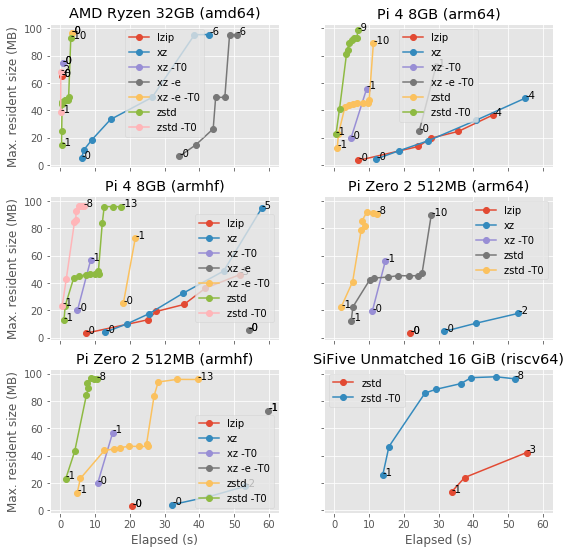

In [53]:
render_multi_xy(conn.execute("""
SELECT
    machine_arch,
    compressor_options,
    level,
    comp_duration AS "Elapsed (s)",
    comp_max_mem / 1048576.0 AS "Max. resident size (MB)"
FROM analysis
WHERE succeeded = 1
AND comp_duration < 60
AND comp_max_mem < (100 * 1048576)
AND compressor IN ('zstd', 'xz', 'lzip')
ORDER BY machine_arch, compressor_options, level_order
"""))

On the Pi Zero 2 at least, the `xz` and `lzip` compressors are sufficiently slow
and/or memory heavy that only the `-0` option is realistic (especially when
parallelism is added with `-T0`). However, on the SiFive, on `zstd` appears below
the 60s margin. If `xz` or `lzip` are selected, SiFive would therefore require an
override.

Returning to our concern about the memory usage of `zstd`, it is worth bearing
in mind that since the Impish release of Ubuntu (21.10), the
Ubuntu Pi kernel has shipped with a cut down list of modules which can be
expanded by installing the `linux-modules-extra-raspi` package. This can boost
the size of the initramfs quite substantially (which was a large part of the
motivation in splitting the modules out in the first place). Would this
affect the memory usage of these compressors? In other words, is memory usage
determined partly by input size, or solely by compression level?

As it happens, our input sizes are specific to each architecture and vary
fairly widely in size:

In [30]:
render_table(conn.execute("""
SELECT DISTINCT
    arch AS "Arch",
    ROUND(input_size / 1048576.0, 1) AS "Size (MB)"
FROM results
WHERE succeeded = 1
ORDER BY 2
"""))

Arch,Size (MB)
armhf,56.2
arm64,74.0
amd64,174.8
riscv64,647.2


Given this, we can query the memory usage of these algorithms by compression level and
architecture to take a reasonable guess at its memory usage patterns:

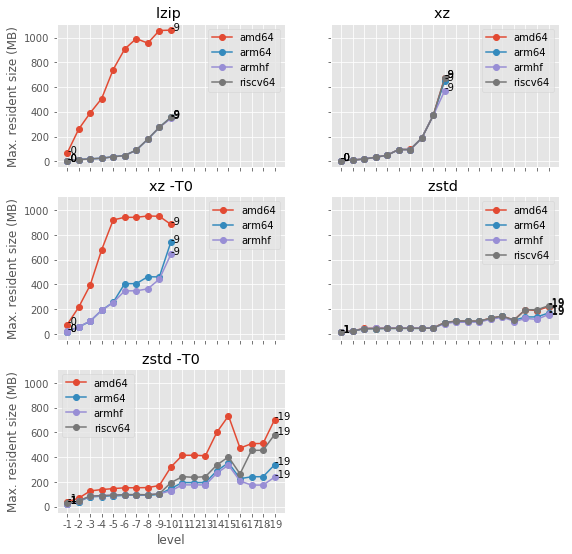

In [56]:
render_multi_xy(conn.execute("""
SELECT
    compressor || ' ' || options,
    arch,
    level,
    level AS "level",
    comp_max_mem / 1048576.0 AS "Max. resident size (MB)"
FROM analysis
WHERE succeeded = 1
AND compressor IN ('zstd', 'lzip', 'xz')
AND options IN ('', '-T0')
ORDER BY 1, 2, level_order
"""))

Something *very* strange is going on with `lzip` which appears to have a
fundamentally different memory usage on `amd64` despite it sitting in the middle
of the input sizes. For all the rest, the `-T0` (parallel) variants demonstrate
*some* variation in memory usage but typically only at the upper levels. The
lower levels could be considered close(ish) to constant-mem.

Nonetheless, the levels from `-3` onwards (in the serial variants, `-0` in the
parallel ones) all skirt very close to the 50MB "danger zone" on the
Pi Zero 2. Further, given an algorithm that explicitly varies with input size
there's no strong guarantee that later versions (or option changes) won't push
us slightly over some boundary (like 50MB resident usage).

If we selected a compressor with fixed memory usage (O(1) memory complexity),
this concern is substantially alleviated. From playing with the interactive
charts earlier, we can guess that `lz4` and `gzip` demonstrate such behaviour,
but let's confirm this by querying which compressors (and options) demonstrate
no more than 1MB of difference between their minimum and maximum memory usage
per machine (and arch):

In [57]:
render_table(conn.execute("""
SELECT
    compressor_options AS "Command",
    arch AS "Architecture",
    ROUND((MAX(comp_max_mem) - MIN(comp_max_mem)) / 1048576.0, 1) AS "Mem Range (MB)"
FROM analysis
WHERE succeeded = 1
AND compressor <> 'cat'
GROUP BY 1, 2
HAVING MAX(comp_max_mem) - MIN(comp_max_mem) <= 1048576
"""))

Command,Architecture,Mem Range (MB)
bzip2 -s,amd64,0.8
bzip2 -s,arm64,0.9
bzip2 -s,armhf,0.8
bzip2 -s,riscv64,0.8
gzip,amd64,0.1
gzip,arm64,0.1
gzip,armhf,0.1
gzip,riscv64,0.1
lz4,amd64,0.4
lz4,arm64,0.4


As suspected, `lz4` and `gzip` are (for our limited range of inputs at least),
effectively constant memory compressors.
Intriguingly, `bzip2` has a `-s` option which, according to the [manpage], is
intended to "reduce memory-usage". In fact, it seems to switch it from an
algorithm which varies (minimally) in memory usage to one that uses a fixed (?)
size buffer. It would be ideal if `zstd` had such a switch (not to mention
`xz` and `lzip`)!

However, we've already eliminated `bzip2` over other performance concerns, and
`zstd` from levels `-3` are so close to our 50MB memory limit that we should
try and seek a reasonable alternatives if we can. `zstd` levels `-1` and `-2`
look good, but their compression ratios may not be competitive against other
combinations. How do these compare to the `lz4` and `gzip` compressors (at any
of their levels)? We'll limit the query to runs that took less than 30 seconds
and less than 50MB of resident memory:

[manpage]: https://manpages.ubuntu.com/manpages/jammy/en/man1/bzip2.1.html

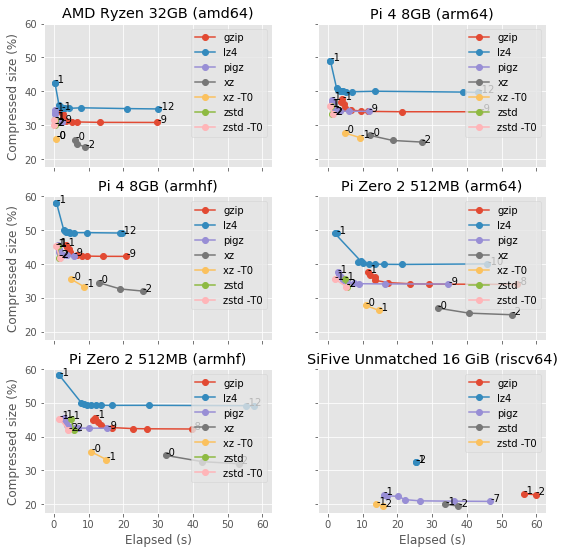

In [62]:
render_multi_xy(conn.execute("""
SELECT
    machine_arch,
    compressor_options,
    level,
    comp_duration AS "Elapsed (s)",
    comp_ratio AS "Compressed size (%)"
FROM analysis
WHERE succeeded = 1
AND comp_duration < 60
AND comp_max_mem < (100 * 1048576)
AND (
    compressor IN ('gzip', 'pigz', 'lz4')
    OR (
        compressor IN ('zstd', 'xz')
        AND options IN ('', '-T0')
        AND level IN ('-0', '-1', '-2')
    )
)
ORDER BY machine_arch, compressor_options, level_order
"""))

The `-1` and `-2` levels of `zstd` look extremely good from these graphs,
typically producing slightly better compression than `gzip` in roughly half the
time.

By comparison, `lz4` barely seems competitive and I have to wonder whether the
move from `gzip` to `lz4` in initramfs-tools was worthwhile (perhaps we'll
see some difference when analyzing the decompression performance)? On the other
hand, `pigz` looks excellent. It competes happily with `zstd` at the lower
levels. Unfortunately it's not in "main" so it's not a realistic option right
now. Still, worth considering for the future (especially given initramfs-tools
already uses it when it's present).

## Decompression comparisons

So far we've ignored the decompression side of things entirely. We should have
a quick look at the performance of all the compressors to get a quick feel for
things:

In [63]:
@widgets.interact(value=widgets.Dropdown(
    options=all_machines_archs,
    description='Machine'
))
def compare_compressors(value):
    machine, arch = value
    query = """
    SELECT
        compressor_options,
        level,
        decomp_duration AS "Elapsed (s)",
        decomp_max_mem / 1048576.0 AS "Max. resident size (MB)",
        comp_ratio AS "Compressed size (%)"
    FROM analysis
    WHERE succeeded = 1
    AND machine = ?
    AND arch = ?
    AND compressor <> 'cat'
    ORDER BY compressor_options, level
    """
    render_xyz(conn.execute(query, (machine, arch)))
    plt.show()

interactive(children=(Dropdown(description='Machine', options=(('AMD Ryzen 32GB (amd64)', ('AMD Ryzen 32GB', '…

The graphs above do show that `xz`, `lzip` and `bzip2` are all significant
outliers in terms of decompression performance: far slower than `lz4`, `gzip`
and `zstd`. The LZMA compressors also use serious amounts of memory for
decompression at their higher levels (bear in mind that at the higher levels,
the Pi Zero 2 failed to run these algorithms and so there's no decompression
data for them either).

Also notable is that `lz4` is definitively quicker than `gzip` at all levels.
Given that the initramfs is presumably read (and thus decompressed) more than
it is written (and compressed), this does make a reasonable case for the use of
`lz4` (at certain levels; the `-9` level currently used by initramfs-tools is
almost certainly not worthwhile in terms of compression performance).

## Limits

Let's try and quantify some of this with the limits we've explored above:

* We're only interested in compressors, options and levels which can
  consistently operate in less than 50MB of memory, and in less than 30s
  of runtime

* We'll define some I/O speeds for reading the initramfs on various
  architectures:

  - 10MB/s on `armhf` and `arm64` as that's a typical SD card speed
  - 250MB/s on `amd64` as that's a reasonable SSD/NVMe speed

* 20 reads of the initramfs (boots) per write (per kernel upgrade essentially)
  This is highly speculative. It could be 1 (never rebooted except on kernel
  upgrades), or effectively infinite (an ephemeral cloud image that only ever
  reads the initramfs on boot, but never upgrades it and so never writes it).

Starting from these assumptions, here's an interactive table which shows
compressors, their options, and a level, limited to those combinations which
successfully run in the defined limits, ordered by their overall "score":
the sum of the compression time, the time to read and decompress the
compressed output a certain number of times (20 by default), summed across
all sampled machines.
Also shown are some of the ranges (duration and compression ratio) achieved
by the specified combination.

The table is limited to 20 rows of output for brevity. You can modify the
limits and reads per write ratio with the sliders to try different limits and
scenarios:

In [64]:
@widgets.interact(
    mem_limit=widgets.IntSlider(
        value=50, min=10, max=200,
        description='Memory limit (MB)',
        readout_format='d'),
    duration_limit=widgets.IntSlider(
        value=30, min=5, max=60,
        description='Duration limit (s)',
        readout_format='d'),
    reads_per_write=widgets.IntSlider(
        value=20, min=1, max=100,
        description='Reads per write',
        readout_format='d'))
def compare_compressors(mem_limit=50, duration_limit=30, reads_per_write=20):
    query = """
WITH all_machines AS (
    SELECT DISTINCT machine, arch
    FROM results
),
valid_compressors AS (
    -- Find only those compressor options and levels
    -- which successfully ran within the limits
    -- for *all* sampled machines and archs
    SELECT compressor, options, level
    FROM results
    WHERE succeeded = 1
    AND comp_max_mem < (? * 1048576)
    AND comp_duration < ?
    GROUP BY compressor, options, level
    HAVING COUNT(*) = (SELECT COUNT(*) FROM all_machines)
)
SELECT
    compressor AS "Compressor",
    options AS "Options",
    level AS "Level",
    ROUND(SUM(
        comp_duration +
        (
            output_size / (
                CASE arch
                    -- Per arch I/O speeds
                    WHEN 'amd64' THEN 250
                    WHEN 'armhf' THEN 10
                    WHEN 'arm64' THEN 10
                    -- Fail (div/0) for undefined archs
                    ELSE 0
                END * 1048576.0
            ) +
            decomp_duration
        ) * ?
    ), 2) AS "Total 'Duration'",
    ROUND(MAX(comp_max_mem) / 1048576.0, 2) AS "Max res. size (MB)",
    CAST(MIN(comp_duration) AS VARCHAR) || ' - ' ||
    CAST(MAX(comp_duration) AS VARCHAR) AS "Comp. duration (s)",
    CAST(ROUND(MIN(100.0 * output_size / input_size), 2) AS VARCHAR) || ' - ' ||
    CAST(ROUND(MAX(100.0 * output_size / input_size), 2) AS VARCHAR) AS "Ratio (%)"
FROM results
    JOIN valid_compressors USING (compressor, options, level)
GROUP BY compressor, options, level
ORDER BY 4
LIMIT 20
    """
    return render_table(conn.execute(query, (
        mem_limit, duration_limit, reads_per_write)))

interactive(children=(IntSlider(value=50, description='Memory limit (MB)', max=200, min=10), IntSlider(value=3…

Playing around with the queries above, I conclude the following:

* The duration limit beyond 20s makes little to no difference to the results

* There is largely no point in going beyond `zstd -8` even on huge platforms.
  Even maximizing the memory limits and reads per write, the higher levels
  like `-10` do not approach the top of the table suggesting the compression
  gains made are either negligible or outweighed by increased decompression
  time

* If memory is no object, `zstd -T0` is unassailable. At few reads per write,
  `zstd -T0 -1` wins. At many reads per write, `zstd -T0 -8` wins. However, this
  requires a considerable memory commitment (150MB+)

* With a 50MB memory limit (our original assumption) `zstd -2` is usually best.
  Occasionally `zstd -T0 -1` wins but `-2` has preferable memory usage

* If we tighten our memory constraint down to 30MB, `lz4` at a couple of levels
  becomes competitive with `zstd -2`

* Tighter still, to 20MB, and `lz4` comes to dominate (though `zstd -1` still
  appears in the table at various points)

* It is interesting to see `cat` (no compression) show up near (though never
  at) the top of the table in various configurations

## Conclusion

`zstd` at the lower levels (`-1` or `-2`) is clearly an excellent choice and
likely "safe" eve on smaller platforms. However it is worth bearing in mind that
even a tight limit of 20MB of resident memory still represents nearly 10% of the
*available* memory on the Pi Zero 2 arm64 platform at runtime. Hence, we should
aim to be as conservative as we reasonably can on memory usage.

To that end, given that `lz4` appears to demonstrate more or less constant
memory usage (or is at least considerably less affected by input size than
`zstd`), it is probably the safest choice for the default initramfs compressor.
However, its current configuration in initramfs-tools (using the `-9` level)
should be altered. There is no benefit to using such a high level, while there
are several downsides including excessive runtime and achieving little to no
extra compression. The `-3` or `-4` levels appear to confer the best trade-off
between runtime and compression ratio in a variety of configurations.

It is also notable that, at the time of writing, initramfs-tools offers no
option for *disabling* compression (e.g. "none" of some other suitable value).
On platforms with slower I/O, like the Pi, compression is still an important
tool. However, as storage gets faster, compressors matter less or, conversely,
compressors have to work faster and better to remain relevant:

Consider a typical uncompressed initramfs of 80MB. On a platform with I/O
capable of a sustained 10MB/s transfer rate, this would take 8 seconds to load.
If we compress it to half the size (40MB), it now takes 4 seconds to load, and
the decompressor has a leisurely 4 seconds to decompress it in order to "beat
the time" of the uncompressed load.

However, on a machine with a 240MB/s transfer rate (to keep the maths simple),
the uncompressed archive would take ⅓ of a second to load. If we compress it to
half the size, it takes ⅙ of a second to load and the decompressor has to unpack
it in another ⅙ of a second in order to perform better than a straight
uncompressed load. There is presumably some lower bound for the speed of the
decompressor, and it may be that at some future point storage speeds advance to
the point that compression (for initramfs archives at least) becomes moot. We're
not there yet, but the presence of `cat` near the top of the table in certain
configurations above suggests it should be a configuration we at least support.